In [1]:
#Import Packages
import pandas as pd
import numpy as np
import os
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime
import matplotlib
from herbie import Herbie
import pickle
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pysolar.solar as solar
from geographiclib.geodesic import Geodesic
import xarray as xr
import pytz
import simplekml
import cartopy
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting


pd.options.mode.chained_assignment = None


#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

In [2]:
base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
#base_project_dir = '/Users/agmeyer4/LAIR_1/'


#SLC SOURCES
slc_sources = dict(
    landfill = {'salt_lake_valley':{'lat':40.746,'lon':-112.042},
                 'trans_jordan':{'lat':40.55862,'lon':-112.053},
                 'davis':{'lat':41.114,'lon':-111.931},
                 'weber':{'lat':41.218,'lon':-111.99},
                 'bountiful':{'lat':40.911,'lon':-111.917}},
    ww_plant = {'central_valley':{'lat':40.7036613,'lon':-111.9141398},
                 'big_cottonwood':{'lat':40.6187424,'lon':-111.7824328},
                 'se_regional':{'lat':40.5411975,'lon':-111.8191652},
                 'south_valley':{'lat':40.5033357,'lon':-111.9187493},
                 'slc':{'lat':40.8030915,'lon':-111.9295899},
                 },
    refinery = {'Chevron':        {'lat':40.825,'lon':-111.924},
                  'Big West Oil':   {'lat':40.838,'lon':-111.920},
                  'Marathon':       {'lat':40.794,'lon':-111.909},
                  'Holly Refining': {'lat':40.887,'lon':-111.904},
                  'Silver Eagle':   {'lat':40.868,'lon':-111.910}}
    )

source_df = pd.DataFrame()
for sourcetype in slc_sources.keys():
    df = pd.DataFrame(slc_sources[sourcetype]).transpose()
    df['type'] = sourcetype
    source_df = pd.concat([source_df,df])

# Slant Columns: A Step By Step Description

Our goal is to create a list of receptor details (datetime, lat, lon, zagl) that can be used as an input to the STILT model for footprint analyses.

The required input variables to accomplish this are the latitude, longitude, and elevation (m above sea level) of the solar spectrometer (EM27), the datetime of the measurment, and the vertical levels at which we want to release particles.

The output should be a file formatted such that it can be read by STILT for particle releases. 

The following description is effectively a step by step of ac_funcs.ground_slant_handler.run_slant_at_intervals() for a single time (not a range, that is below). 

1. Define our receptor location and datetime details

In [3]:
#First define the instrument location and elevation
inst_lat = 40.766
inst_lon = -111.847
inst_zasl = 1492 #instrument elevation in meters above sea level

#Next define the datetime range
dt1_str = dt2_str = '2022-06-16 18:00:00' #start datetime
timezone = 'UTC' #this should nearly always be UTC, but can identify if your datetime strings above are in a different timezone

#Now format the datetime and timezone into useful formats
dt1 = ac.dtstr_to_dttz(dt1_str,timezone)
dt2 = ac.dtstr_to_dttz(dt2_str,timezone)

3. Next we define the vertical levels from which we wish to release particles. Starting point of level release heights (above the level of the instrument) for now is Taylor Jones' Indianapolis work (https://doi.org/10.5194/acp-21-13131-2021)

In [4]:
#Define the heights above the instrument (in m) from which we would like to release particles
z_ail_list = [0,25,50,75,100,150,200,300,400,600,1000,1500,2000,2500]

Lets plot the particle release heights above the instrument

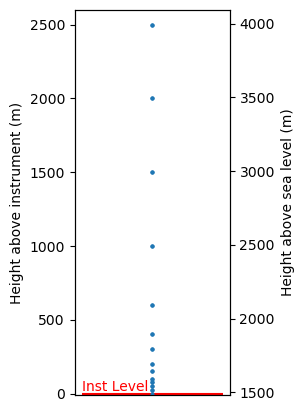

In [5]:
#Simple plot to show the particle release heights both above the instrument and above sea level

# Create the list of particle release elevations above sea level -- this is done in ac.load_singletime_hgtdf (in a cell below), but show it manually for now:
z_asl_list = [x+inst_zasl for x in z_ail_list]

#Make the plot
x = np.zeros_like(z_ail_list)
fig,ax = plt.subplots(figsize = (2,5))
ax.scatter(x,z_ail_list,s=4)
ax.set_ylabel('Height above instrument (m)')
ax.set_ylim([min(z_ail_list)-10,max(z_ail_list)+100])
ax2 = ax.twinx()
ax2.scatter(x,z_asl_list,s=4)
ax2.set_ylabel('Height above sea level (m)')
ax2.set_ylim([min(z_asl_list)-10,max(z_asl_list)+100])
ax.hlines(0,-1,1,color='red')
ax.tick_params(labelbottom = False, bottom = False)
ax.text(-1,20,'Inst Level',color='red')
plt.show()

4. With the above input parameters, we're ready to start building our dataframe of receptor locations. Because we are releasing particles at a vertical level above the instrument location *along the slanted column of the sun*, we need to find the lat/lon coordinates of each receptor point along that slanted column. 

    To do this, we use ac.ground_slant_handler() to build the dataframe. Our fist step is to use ac.ground_slant_handler.create_initial_slantdf(). This uses the ac.slant_lat_lon() function to get the new coordinates. We use basic geometry and an ellipsoid earth model to output lat/lon of the release points on the slant column given the datetime of the observation (for calculating what the slant column looks like). 

In [6]:
#Create the ground slant handler 
gsh = ac.ground_slant_handler(inst_lat,inst_lon,inst_zasl,z_ail_list)
#Create the list of datetimes, in our case it will just be one datetime since the start and end are the same
dt_list = ac.create_dt_list(dt1,dt2,'1H') #the interval doesn't matter here because it's only one time
initial_slantdf = gsh.create_initial_slantdf(dt_list) #create the dataframe from the inputs

Adding receptor lat/lons along the slant column


/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Atmos_Column/atmos_column/ipynbs/../funcs/ac_funcs.py:336: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt_index = pd.date_range(dt1,dt2,freq=interval)


Now we have a dataframe (slant_df) that has receptors at each of our input z release points, with the correct latitude longitude of those points along the slant column. We can visualize it below using a helping plotly function. 

In [8]:
plotting.create_slant_plots(initial_slantdf,inst_lat,inst_lon)

5. STILT uses receptor heights **above ground level** not above sea level, so we must account for this. To do so, we use surface height elevation from DEM files. More info in dem_dev.ipynb. For now I am using ASTER dems for everything, a change from using HRRR .grib2 files. Some dangling code regarding hrrr

In [ ]:
# Running this will load create the DEM handler 
dem_folder = os.path.join(base_project_dir,'Data/DEM/')
dem_fname = 'ASTGTM_NC.003_30m_aid0001_slcbig.nc'
dem_typeid = 'aster'

With the DEM defined, we now need to find the surface height for each point in our receptor slant_df. Basically we take the lat/lon of the receptor and find the nearest grid cell in the DEM dataset by setting a distance value for each centerpoint. From the minimum distance value, we grab the surface elevation. This is done using my_dem_handler

In [ ]:
# This shows how we are getting the surface elevation for a point. In this case, we use the instrument location and extract the height. This is dem_handler.get_nearest_elev
my_dem_handler = ac.DEM_handler(dem_folder,dem_fname,dem_typeid) #define the handler
pt_lat = 40.768#inst_lat
pt_lon = -111.854#inst_lon

dem_df = my_dem_handler.get_sub_dem_df(pt_lat,pt_lon)
dem_df['dist'] = np.vectorize(ac.haversine)(dem_df[my_dem_handler.dem_latname],dem_df[my_dem_handler.dem_lonname],pt_lat,pt_lon) #add a distance column for each subpoint using haversine
idx = dem_df['dist'].idxmin() #find the minimum distance
nearest = dem_df.loc[idx]
surface_height = dem_df.loc[idx][my_dem_handler.dem_dataname] #return the value requested

In [ ]:
dem_xarr_plot = dem_df.set_index([my_dem_handler.dem_latname,my_dem_handler.dem_lonname]).to_xarray()

center_pt = [pt_lat,pt_lon]
zoom = 0.001
extent = [center_pt[1]-(zoom),center_pt[1]+(zoom),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)
ax.set_extent(extent,crs=proj)
request = cimgt.QuadtreeTiles()
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
ax.add_image(request,int(scale))
dem_plot = dem_xarr_plot[my_dem_handler.dem_dataname].plot.pcolormesh(ax = ax,alpha=0.5,cmap='Reds',add_colorbar=False,edgecolor = 'k',linewidth=0.005)
plt.colorbar(dem_plot,fraction=0.02,label ='Geopotential height (m above sea level)')
plt.scatter(pt_lon,pt_lat,s=30,c='black')
plt.text(pt_lon,pt_lat,'requested')
plt.scatter(nearest[my_dem_handler.dem_lonname],nearest[my_dem_handler.dem_latname],s=30,c='blue')
plt.text(nearest[my_dem_handler.dem_lonname],nearest[my_dem_handler.dem_latname],f'nearest = {round(surface_height,1)} MASL')
plt.show()

Using the above, we adapt the slant_df to have the surface elevations and the appropriate "above ground level" elevations for each receptor. We also add a column that indicates whether the receptor is actually above the ground level. In the case of a low sun angle over the mountains, the receptor points can be "below ground level" so we want to know which points this is true for. 

In [ ]:
slant_df = ac.add_sh_and_agl(initial_slantdf,my_dem_handler)

Now we can plot the slant column with the above ground level information.

In [ ]:
plotting.create_slant_plots(slant_df,inst_lat,inst_lon)

### The above shows the slant column creation from a single, manual instrument location and datetime. We also want to be able to create these for periods of time at specified intervals. This will allow us to get a receptor column for a full day/days.

1. Setup things much like above, this time with a range for our datetimes and a specified interval. 

In [ ]:
#Define instrument parameters
inst_lat = 40.766
inst_lon = -111.847
inst_zasl = 1492 #instrument elevation in meters above sea level

#define datetime range and interval parameters
dt1_str = '2022-06-16 00:00:00'#start datetime
dt2_str = '2022-06-17 00:00:00' #end datetime
interval = '1H' #interval at which we want our dataframe
timezone = 'UTC' #this should nearly always be UTC, but can identify if your datetime strings above are in a different timezone

#Define the heights above the instrument (in m) from which we would like to release particles
z_ail_list = [0,25,50,75,100,150,200,300,400,600,1000,1500,2000,2500]

#Now format the datetime and timezone into useful formats
dt1 = ac.dtstr_to_dttz(dt1_str,timezone)
dt2 = ac.dtstr_to_dttz(dt2_str,timezone)

# Running this will load create the DEM handler 
dem_folder = os.path.join(base_project_dir,'Data/DEM/')
dem_fname = 'ASTGTM_NC.003_30m_aid0001_slcbig.nc'
dem_typeid = 'aster'
my_dem_handler = ac.DEM_handler(dem_folder,dem_fname,dem_typeid) #define the handler

2. Create the ground slant handler and use the run_slant_at_intervals function to get our correct multiindexed dataframe for all receptor levels. 

In [ ]:
gsh = ac.ground_slant_handler(inst_lat,inst_lon,inst_zasl,z_ail_list)
slant_df = gsh.run_slant_at_intervals(dt1,dt2,my_dem_handler)

3. We can now plot this range of slant columns. 

In [ ]:
plotting.create_slant_plots(slant_df,inst_lat,inst_lon)

### We now want to integrate the EM27 data to our building of the slant receptor columns

Now we want to be able to use information from EM27 oof files. The main goal here is twofold: pull the instrument lat/lon from the oof files, and filter the receptor times to times that are included in the oof files, so we don't have to run models on times when we don't have EM27 data to compare to. 

For now, I am doing this on a "daily" basis, where each day of the range is split and the slant_df for each day is created such that the models can be run on that day. This prevents us from having to load a bunch of oof files/slant dfs in a single shot. 

There are some edge cases I haven't quite dealt with yet. The major one is the case where the EM27 is moved to a different lat long within the datetime range that was specified. 

1. Setup the run like above, except this time don't define the inst_lat, inst_lon, inst_zasl. We will pull this from the oof file. 

In [ ]:
#oof_data_folder = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct'#this is where the EM27 data is 
oof_data_folder = os.path.join(base_project_dir,'Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct') #this is where the EM27 data is 

#Define the heights above the instrument (in m) from which we would like to release particles
z_ail_list = [0,25,50,75,100,150,200,300,400,600,1000,1500,2000,2500]

# Running this will load create the DEM handler 
dem_folder = os.path.join(base_project_dir,'Data/DEM/')
dem_fname = 'ASTGTM_NC.003_30m_aid0001_slcbig.nc'
dem_typeid = 'aster'
my_dem_handler = ac.DEM_handler(dem_folder,dem_fname,dem_typeid) #define the handler

In [ ]:
#define datetime range and interval parameters
dt1_str = '2022-10-19 13:00:00'#start datetime
dt2_str = '2022-10-20 03:00:00' #end datetime
timezone = 'UTC' #this should nearly always be UTC, but can identify if your datetime strings above are in a different timezone
dt1 = ac.dtstr_to_dttz(dt1_str,timezone)
dt2 = ac.dtstr_to_dttz(dt2_str,timezone)
my_oof_manager = ac.oof_manager(oof_data_folder,timezone)
oof_df = my_oof_manager.load_oof_df_inrange(dt1,dt2)

2. Use my_oof_manager to load the oof dataframe for the day in question, so that we can get the applicable information. 

In [ ]:
my_oof_manager = ac.oof_manager(oof_data_folder,timezone)
oof_df = my_oof_manager.load_oof_df_inrange(dt1,dt2)

3. Here is where we would check to make sure that there is em27 data for the datetime range. If there isn't, we don't need to create a slant df and associated receptors and should skip to the next time period

In [ ]:
if len(oof_df) == 0:
    print(f'No oof data for {dt1} to {dt2}')
else:
    print(f'Found oof data for {dt1} to {dt2}')

4. Assuming there was data, here's the edge case we would need to handle later. For now, we just check to makes sure the lat/lon/zasl is the same for the entire oof df. 

In [ ]:
cols_to_check = ['inst_lat','inst_lon','inst_zasl']
for col in cols_to_check:
    if not ac.pdcol_is_equal(oof_df[col]):
        raise Exception('{col} is not the same for the entire oof_df. This is an edge case.')
#If we make it through the above, we can pull the values from the dataframe at the 0th index because they are all the same
inst_lat = oof_df.iloc[0]['inst_lat']
inst_lon = oof_df.iloc[0]['inst_lon']
inst_zasl = oof_df.iloc[0]['inst_zasl']

5. Now we get a new dt range from the oof file. We go to the interval before the start of the df for the initial dt and the interval after the end for the last dt. 

In [ ]:
dt1_oof = oof_df.index[0].floor(interval)
dt2_oof = oof_df.index[-1].ceil(interval)

6. Finally, we can use the gleaned oof data to create the slant df at the interval required

In [ ]:
gsh = ac.ground_slant_handler(inst_lat,inst_lon,inst_zasl,z_ail_list)
slant_df = gsh.run_slant_at_intervals(dt1_oof,dt2_oof,my_dem_handler)

Here we can plot and show the multi df. Since there are many rows, we just plot those "on the hour" to show the change throughout the day. 

In [ ]:
plotting.create_slant_plots(slant_df,inst_lat,inst_lon)